# To Buy or not To Buy, that is the Question.
There is always a phrase that floats around, which is "money makes money". This usually comes in the form of investments, such as owning properties, buying bonds, buying rare metals and of course stocks. 

Stock trading always has it risks, and can be complicated to some, which is why those that invest in the stock market, usually rely on a broker or 'hot tip' from friends and family. What if we can reduce the risk and complications for interested parties in investing in the stock market?

This shall be done by building predictive models using data accessible from the internet. As a case study, I will be looking into predicting stock values for Microsoft and eventually reduce to it simple 'Buy', 'Sell' and 'Hold' for week to week trades (day to day cannot be achieved due to data limitation).

In [1]:
#importing all necessary library for this project
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyflux as pf
import scipy.stats as sp
import statsmodels.tsa.api as smt
import statsmodels.tsa.stattools as sm
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression as lr
from sklearn.model_selection import GridSearchCV as GS
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score, auc
from __future__ import division

In [2]:
#functions for evaluating models that will be built throughout the project
def evaluateModel(prediction,actual):
    plt.figure(figsize=(17,7))
    no_grid = {'grid': False}
    prediction.plot(color='red', label='Prediction',**no_grid)
    actual.plot(color='blue', label='Actual',**no_grid)
    plt.legend(loc='best')
    prediction = np.array(prediction.tolist())
    actual = np.array(actual.tolist())
    print 'Pearson Correlation Coeefiecient: ', sp.pearsonr(actual, prediction)
    error2 = [((x-y)/y)**2 for x, y in zip(prediction, actual)]
    print "Normalised RMSE",np.sqrt(np.sum(error2))

In [3]:
def evaluateCls(prediction, actual, classes):
    trackright=0
    for x , y in zip(prediction, actual):
        if (x==y):
            trackright+=1    
    print 'Percentage that was right', trackright/len(actual)
    
    cm = confusion_matrix(prediction, actual)
    fig, ax = plt.subplots()
    im = ax.matshow(cm)
    for (i, j), z in np.ndenumerate(cm):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center',
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
    
    plt.title('Confusion matrix')
    fig.colorbar(im)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    print(classification_report(actual, prediction, target_names=classes))
    if(len(classes)<3):
        print 'Area under the curve (AUC) is:', roc_auc_score(actual, prediction)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, prediction)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        plt.title('Receiver Operating Characteristic')
        plt.plot(false_positive_rate, true_positive_rate, 'b',
        label='AUC = %0.2f'% roc_auc)
        plt.legend(loc='lower right')
        plt.plot([0,1],[0,1],'r--')
        plt.xlim([-0.1,1.1])
        plt.ylim([-0.1,1.1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

## First let's have a quick look at the Microsoft Stock Data
This is a dataset I obtained from Quandl.com's free database 'Wiki EOD Stock Prices'.

In [4]:
msft = pd.DataFrame.from_csv('MSFT.csv')
#interpolate is chosen to fill in potential missing data as this is timeseries data
msft = msft.interpolate()
#changing the index to go from 1986 to 2016
msft = msft.reindex(index=msft.index[::-1])
msft.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
1986-03-13,25.50,29.25,25.5,28.00,3582600.0,0.0,1.0,0.060989,0.069957,0.060989,0.066968,1.031789e+09
1986-03-14,28.00,29.50,28.0,29.00,1070000.0,0.0,1.0,0.066968,0.070555,0.066968,0.069360,3.081600e+08
1986-03-17,29.00,29.75,29.0,29.50,462400.0,0.0,1.0,0.069360,0.071153,0.069360,0.070555,1.331712e+08
1986-03-18,29.50,29.75,28.5,28.75,235300.0,0.0,1.0,0.070555,0.071153,0.068164,0.068762,6.776640e+07
1986-03-19,28.75,29.00,28.0,28.25,166300.0,0.0,1.0,0.068762,0.069360,0.066968,0.067566,4.789440e+07


As there are many properties, let's focus only on the opening stock value
# Let's visualise the data

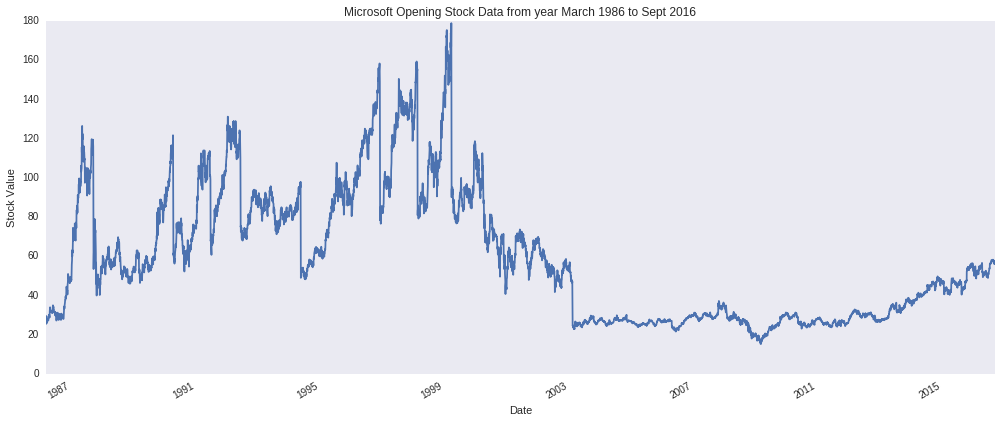

In [5]:
plt.figure(figsize=(17,7))
plt.title('Microsoft Opening Stock Data from year March 1986 to Sept 2016')
plt.xlabel('Time (Year)')
plt.ylabel('Stock Value')
msft.Open.plot(grid=False)

There isn't any obvious trend, and instead many fluctuations throughout.


# ARIMA model

Let's first try and use a time series model that can predict stock prices for an extended period using just the stock data. The time series model of choice will be ARIMA (Autoregressive Integrated Moving Average) model.

To do this, I will be applying the box-jenkins method, which is to first check if the model is stationary.


In [6]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    #Determining Rolling Statistics
    
    rolmean=timeseries.rolling(window=12,center=False).mean()
    rolstd=timeseries.rolling(window=12,center=False).std()
    
    #Plot Rolling Statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.grid(b=False)
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dicket Fuller Test:'
    dftest=adfuller(timeseries, autolag='AIC')
    dfoutput=pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key]=value
    print dfoutput


But first let's divide the data up between training and testing which will be 80:20 ratio of the whole dataset.

In [7]:
trainData = msft.Open[:(int)(len(msft.Open)*0.8)]
testData = msft.Open[(-(int)(len(msft.Open)*0.2)):]

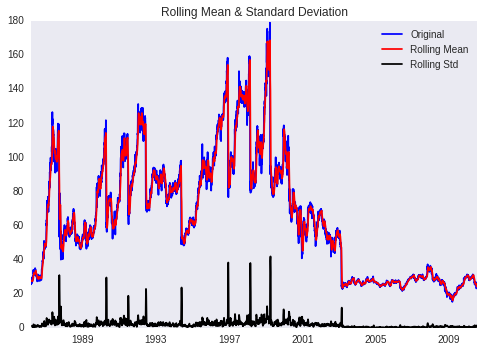

Results of Dicket Fuller Test:
Test Statistic                   -3.045071
p-value                           0.030894
#Lags Used                        2.000000
Number of Observations Used    6142.000000
Critical Value (5%)              -2.862011
Critical Value (1%)              -3.431415
Critical Value (10%)             -2.567021
dtype: float64


In [8]:
test_stationarity(trainData)

The test statistic has a lower value than the 5% critical but higher than the 1% critical value which indicates that this is a stationary series with 95% confidence. So there is no need make the data stationary and can proceed straight to model construction.

But, first let's find out the parameters for the model.

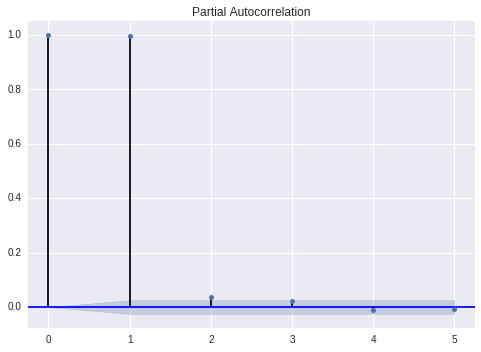

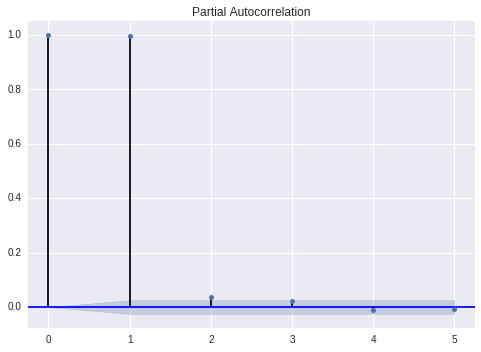

In [9]:
##determines AR order
smt.graphics.plot_pacf(trainData, lags=5)

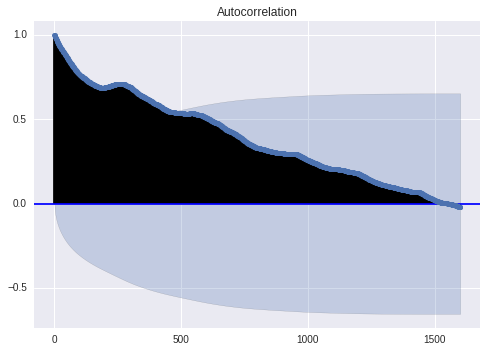

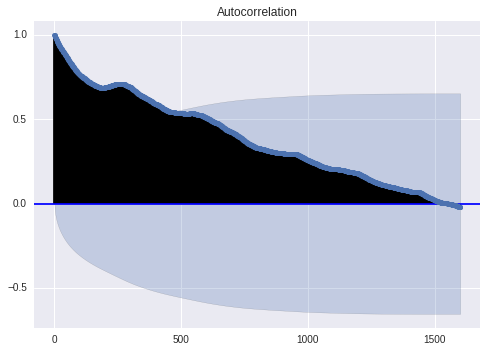

In [10]:
##determines MA order
smt.graphics.plot_acf(trainData, lags=1600)

As the partial autocorrelation function is extremely high, let's construct AR instead of ARIMA model.

In [11]:
msftTrain = msft[:(int)(len(msft.Open)*0.8)]

In [12]:
arimapf=pf.ARIMA(msftTrain, ar=4, ma=0, integ=0,target='Open')
fit=arimapf.fit()

In [13]:
prediction= arimapf.predict(h=2250).Open

In [14]:
testOutput = msft.loc[prediction.index].Open
testOutput = testOutput.interpolate()

Pearson Correlation Coeefiecient:  (0.38177993272276134, 5.5106299566473624e-79)
Normalised RMSE 48.148250407


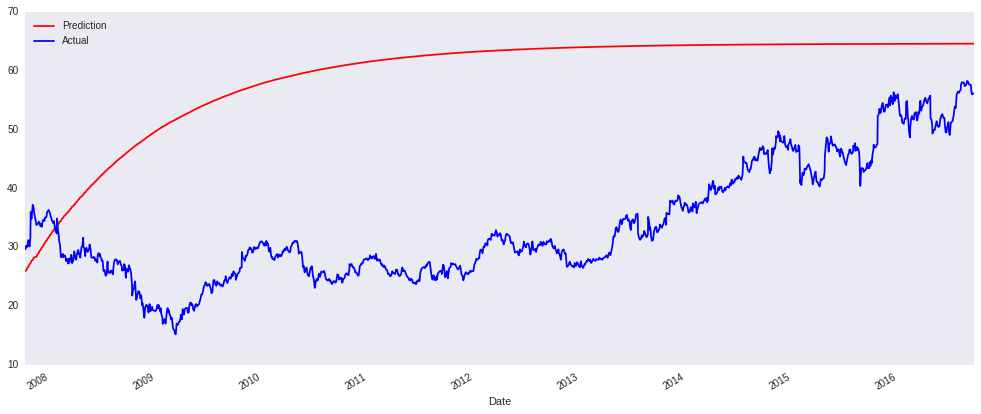

In [15]:
evaluateModel(prediction, testOutput)

It seems ARIMA alone isn't sufficient to make stable accurate predictions using available data. As the stock market is heavily influenced by many factors. Hence, to better model the stock data, additional dataset will be used.

The additional dataset will be investor sentiments on stock market, which is also obtained from Quandl.com's free database 'AAII Investor Sentiment Survey'. This dataset measures the percentage of individual investors' sentiments who are bullish (thinks the market will do well), bearish (thinks the market value will drop), and neutral on the stock market. Individuals are polled from the ranks of the AAII membership on a weekly basis.
# Sentiment Data

In [16]:
investor = pd.DataFrame.from_csv('investor.csv')
investor = investor.fillna(investor.mean())
#changing the index to go from 1987 to 2016
investor = investor.reindex(index=investor.index[::-1])

In [17]:
investor.head()

,Bullish,Neutral,Bearish,Total,Bullish 8-Week Mov Avg,Bull-Bear Spread,Bullish Average,Bullish Average + St. Dev,Bullish Average - St. Dev,S&P 500 Weekly High,S&P 500 Weekly Low,S&P 500 Weekly Close
Date,,,,,,,,,,,,
1987-06-26,0.384424,0.312702,0.302874,0.999999,0.384009,0.08155,0.386014,0.489178,0.28285,1038.23181,1011.831541,1026.840289
1987-07-17,0.384424,0.312702,0.302874,0.999999,0.384009,0.08155,0.386014,0.489178,0.28285,314.59000,307.630000,314.590000
1987-07-24,0.360000,0.500000,0.140000,1.000000,0.384009,0.22000,0.386014,0.489178,0.28285,311.39000,307.810000,309.270000
1987-07-31,0.260000,0.480000,0.260000,1.000000,0.384009,0.00000,0.386014,0.489178,0.28285,318.66000,310.650000,318.660000
1987-08-07,0.560000,0.150000,0.290000,1.000000,0.384009,0.27000,0.386014,0.489178,0.28285,323.00000,316.230000,323.000000


As Microsoft's data are daily whilst sentiment data is weekly, microsoft's data needs to be cleaned up to match the sentiment data.

In [18]:
weekholder1 = investor.drop(investor.index[-1]).index
weekholder2 = investor.drop(investor.index[0]).index
Open = []
Close = []
High = []
Low = []
volume=[]
for week1, week2 in zip(weekholder1, weekholder2):
    Open.append(np.mean(msft.Open.loc[week1:week2]))
    Close.append(np.mean(msft.Close.loc[week1:week2]))
    High.append(np.mean(msft.High.loc[week1:week2]))
    Low.append(np.mean(msft.Low.loc[week1:week2]))
    volume.append(np.mean(msft['Adj. Volume'].loc[week1:week2]))
msftweek = pd.DataFrame(index=weekholder2, data={'Open': Open, "Close":Close, "High":High, "Low":Low, "Volume":volume})
cols = ['Open','Close','High','Low', 'Volume']
msftweek=msftweek[cols]
msftweek.head()

,Open,Close,High,Low,Volume
Date,,,,,
1987-07-17,100.133333,99.866667,101.783333,98.000000,80762880.0
1987-07-24,100.125000,99.541667,101.166667,98.291667,64905600.0
1987-07-31,98.666667,98.000000,99.416667,96.625000,67929600.0
1987-08-07,95.791667,96.875000,98.228333,94.500000,162134400.0
1987-08-14,102.208333,102.500000,103.833333,101.125000,78307200.0


In [19]:
sentiments = investor[['Bullish','Neutral','Bearish']]
sentiments = sentiments[1:]
sentiments.head()

,Bullish,Neutral,Bearish
Date,,,
1987-07-17,0.384424,0.312702,0.302874
1987-07-24,0.360000,0.500000,0.140000
1987-07-31,0.260000,0.480000,0.260000
1987-08-07,0.560000,0.150000,0.290000
1987-08-14,0.450000,0.350000,0.200000


# Linear Regresion Model
Now that I have 2 different datasets, I am going to start building predictive models using sentiments as a feature data, and the stock data as the target.

First, let's start with linear regression model.

I am going to divide up the data in 80:20 ratio for training:test again, just as before.

In [20]:
trainData = sentiments[:(int)(len(sentiments)*0.8)]
testData = sentiments[(-(int)(len(sentiments)*0.2)):]
trainOutput = msftweek.Open[:(int)(len(sentiments)*0.8)]
testOutput = msftweek.Open[(-(int)(len(sentiments)*0.2)):]

In [21]:
regressionmodel =lr()
regressionmodel.fit(trainData, trainOutput)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Pearson Correlation Coeefiecient:  (0.63156765672259596, 3.9232770581924616e-35)
Normalised RMSE 17.11992659


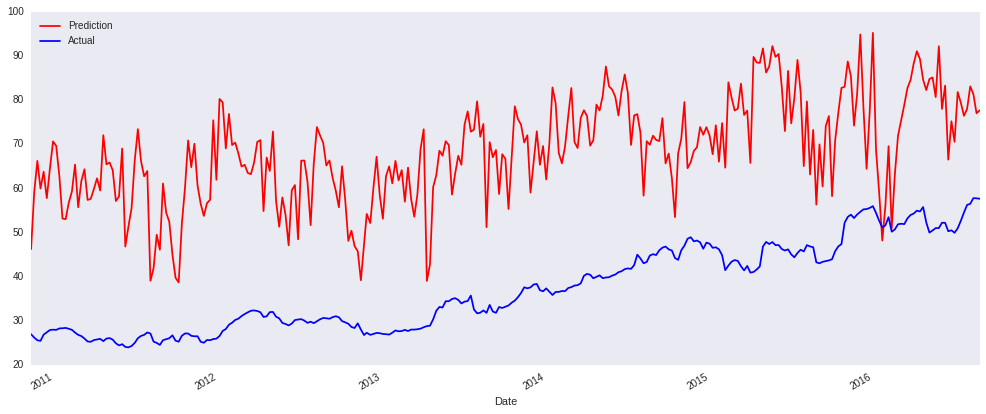

In [22]:
regressionResult = regressionmodel.predict(testData)
regressionResult = pd.Series(regressionResult, testOutput.index)
evaluateModel(regressionResult,testOutput)

Linear regression scored pretty well in correlation function. However, it seemed overly optimistic in prediction and might be due to overfitting. Let's see what happens when I apply bias correction in the prediction.

Pearson Correlation Coeefiecient:  (0.63156765672259585, 3.9232770581925707e-35)
Normalised RMSE 5.73712323119


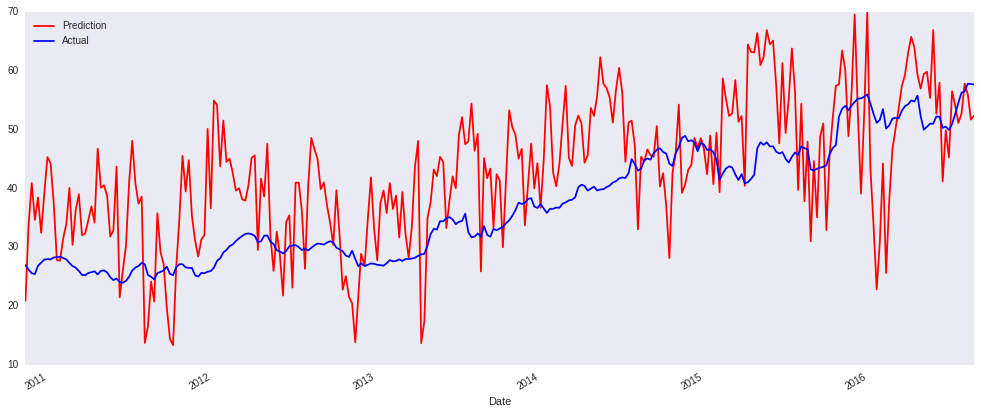

In [23]:
TrainingResult = regressionmodel.predict(trainData)
difference = np.mean(np.abs(TrainingResult - trainOutput))
regressionResult = regressionmodel.predict(testData)
regressionResult = regressionResult - difference
regressionResult = pd.Series(regressionResult, testOutput.index)
evaluateModel(regressionResult,testOutput)

This improves the prediction significantly, as seen in the far lower normalised root mean square error score.  
# Support Vector Machine Regression
However, this isnt' good enough for a predictive model, now let's try other machine learning methods, first with Support Vector Machine (SVM). First let's use the regression function of SVM.


In [24]:
svrModel = SVR()
svrModel.fit(trainData, trainOutput)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

Pearson Correlation Coeefiecient:  (0.58838676843931692, 1.3017510655606388e-29)
Normalised RMSE 14.6063874156


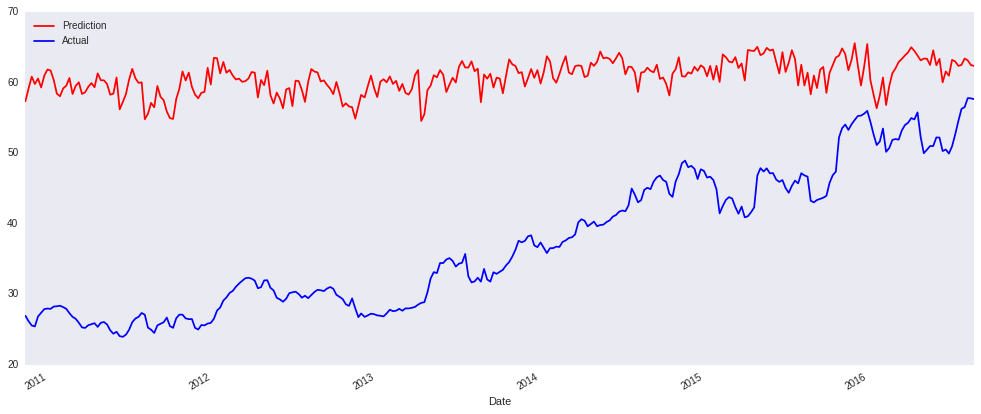

In [25]:
svrResult = svrModel.predict(testData)
svrResult = pd.Series(svrResult, testOutput.index)
evaluateModel(svrResult,testOutput)

It seems SVR model doesn't do as well as linear regression, let's apply bias correction on this as well.

Pearson Correlation Coeefiecient:  (0.58838676843931681, 1.3017510655606718e-29)
Normalised RMSE 3.7125041955


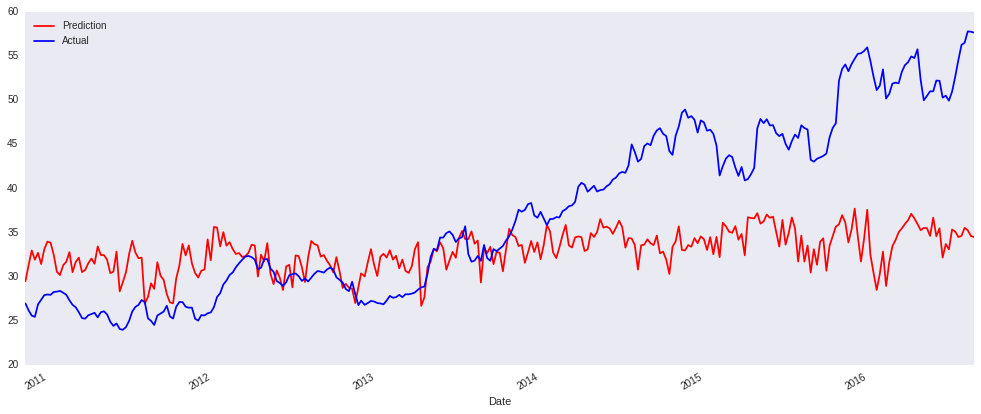

In [26]:
TrainingResult = svrModel.predict(trainData)
difference = np.mean(np.abs(TrainingResult - trainOutput))
svrResult = svrModel.predict(testData)
svrResult = svrResult - difference
svrResult = pd.Series(svrResult, testOutput.index)
evaluateModel(svrResult,testOutput)

It gives improve NRMSE score, however the pearson correlation didn't change and as seen from the graph, this prediction is no good around the year 2014 and beyond.
# Support Vector Machine Classifier
SVM have another function which is a classifier, since the objective of this project is inform investor on whether to buy the stock, maybe the problem can reduced to a classification problem. Let's turn the stock data into classes, which will be if the stock will increase(1) or decrease(-1) in value the day compared to the day before.

In [27]:
#generating the Classes
UpDownCls = []
previousday=msftweek.Open[0]
for stock in msftweek.Open[1:]:    
    if (stock > previousday):
        UpDownCls.append(1)
    else:
        UpDownCls.append(-1)
    previousday = stock
UpDownCls = pd.Series(UpDownCls , index=msftweek.index[1:])
ClsFeatures = sentiments.loc[UpDownCls.index]
trainDataCls = ClsFeatures[:(int)(len(ClsFeatures)*0.8)]
testDataCls = ClsFeatures[(-(int)(len(ClsFeatures)*0.2)):]
trainOutputCls = UpDownCls[:(int)(len(ClsFeatures)*0.8)]
testOutputCls = UpDownCls[(-(int)(len(ClsFeatures)*0.2)):]

In [28]:
svcModel = SVC()
svcModel.fit(trainDataCls,trainOutputCls)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Percentage that was right 0.587458745875


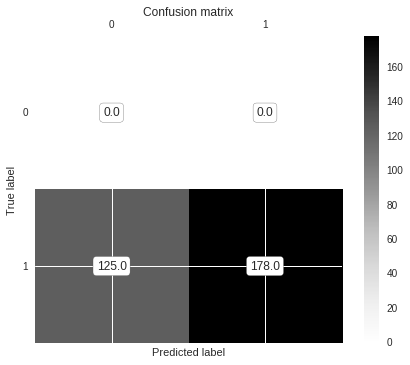

             precision    recall  f1-score   support

         -1       0.00      0.00      0.00       125
          1       0.59      1.00      0.74       178

avg / total       0.35      0.59      0.43       303

Area under the curve (AUC) is: 0.5


/home/chuanfuyap/Applications/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


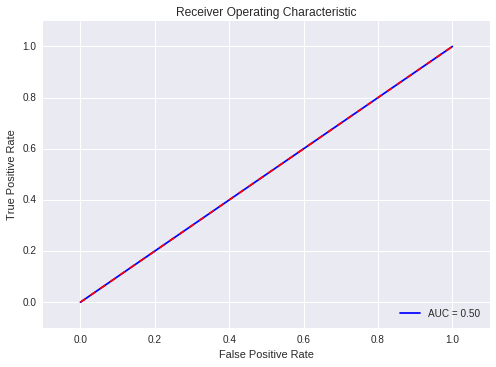

In [29]:
prediction = svcModel.predict(testDataCls)
evaluateCls(prediction, testOutputCls, ['-1', '1'])

Well, it seems the SVC model performed very poorly as it predicted only increase for all the days.

It seems, all these poor performance in SVM models are due to the fact that they aren't optimised with proper parameters. So let's use Grid Search to optimise the models to make better predictions.
# SVM Take Two
All the models from here on will have parameters optimised using Grid_SearchCV function in scikit-learn. However, they have all been done before hand, compilation of them can be seen [here](https://github.com/chuanfuyap/datascienceintensive/blob/master/Grid_Search/GridSearch%20for%20microsoft%20Data.ipynb). So only the optimised parameters will be posted.

In [30]:
svrModel = SVR(C= 100,
 coef0= 1,
 degree= 5,
 epsilon= 0.001,
 gamma= 1,
 kernel= 'poly')
svrModel.fit(trainData,trainOutput)

SVR(C=100, cache_size=200, coef0=1, degree=5, epsilon=0.001, gamma=1,
  kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

Pearson Correlation Coeefiecient:  (0.53633595341482621, 5.7433609063371331e-24)
Normalised RMSE 7.43352033062


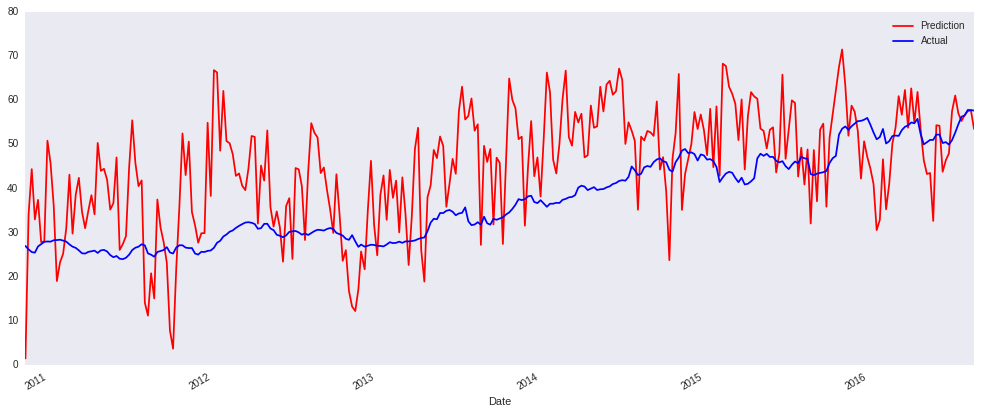

In [31]:
TrainingResult = svrModel.predict(trainData)
difference = np.mean(np.abs(TrainingResult - trainOutput))
svrResult = svrModel.predict(testData)
svrResult = svrResult - difference
svrResult = pd.Series(svrResult, testOutput.index)
evaluateModel(svrResult,testOutput)

In [32]:
svcModel = SVC(C=100, coef0=0.001, degree=4, gamma=1, kernel='poly')
svcModel.fit(trainDataCls,trainOutputCls)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.001,
  decision_function_shape=None, degree=4, gamma=1, kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Percentage that was right 0.597359735974


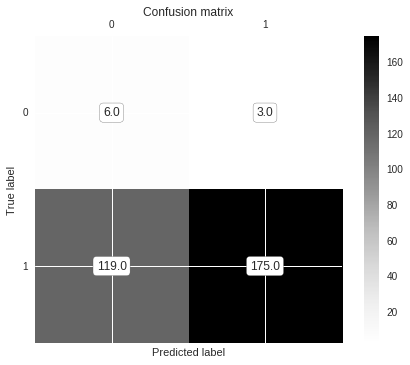

             precision    recall  f1-score   support

         -1       0.67      0.05      0.09       125
          1       0.60      0.98      0.74       178

avg / total       0.62      0.60      0.47       303

Area under the curve (AUC) is: 0.515573033708


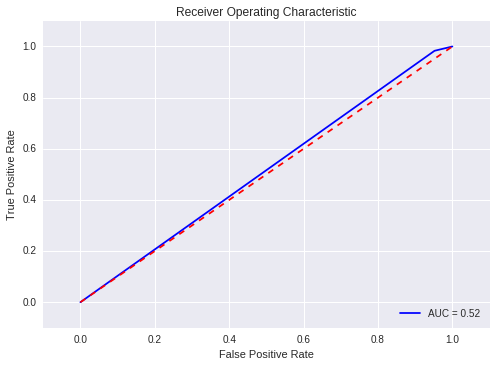

In [33]:
prediction = svcModel.predict(testDataCls)
evaluateCls(prediction, testOutputCls, ['-1', '1'])

It seems, optimising the SVM models didn't really improve the prediction all that much. Maybe a different machine learning method will do better.
# Random Forest Models


In [34]:
randomForestRegression = RFR(
 n_estimators=1000,
 bootstrap= True,
 criterion= 'mae',
 max_features= 'sqrt',
 min_samples_leaf= 3,
 min_samples_split= 2,
 n_jobs= 6,
 oob_score= True)
randomForestRegression.fit(trainData,trainOutput)

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=3,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=6, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

Pearson Correlation Coeefiecient:  (0.4433413542417679, 5.082345918783103e-16)
Normalised RMSE 10.0435315402


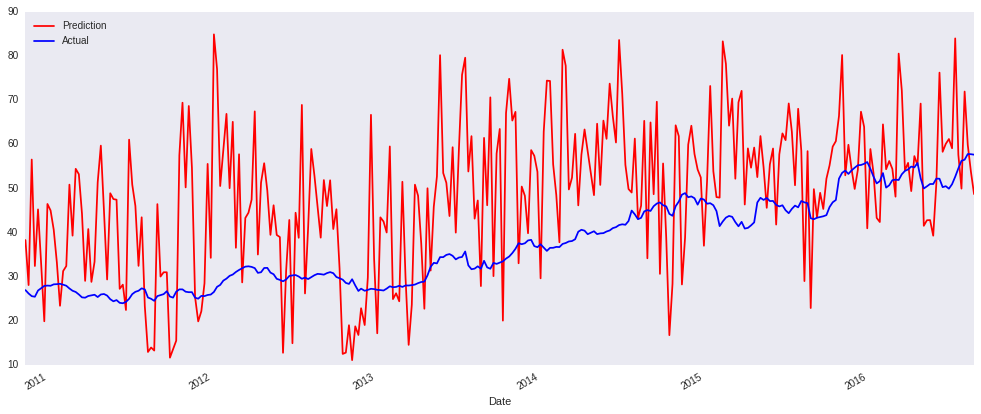

In [35]:
TrainingResult = randomForestRegression.predict(trainData)
difference = np.mean(np.abs(TrainingResult - trainOutput))
rfrResult = randomForestRegression.predict(testData)
rfrResult = rfrResult - difference
rfrResult = pd.Series(rfrResult, testOutput.index)
evaluateModel(rfrResult,testOutput)

In [36]:
randomForestClassifier = RFC(
 n_estimators=1000,
 bootstrap= False,
 criterion= 'gini',
 max_features= 'auto',
 min_samples_leaf= 2,
 min_samples_split= 2,
 n_jobs= 6,
 oob_score= False
    )
randomForestClassifier.fit(trainDataCls,trainOutputCls)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=2,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=6, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

Percentage that was right 0.547854785479


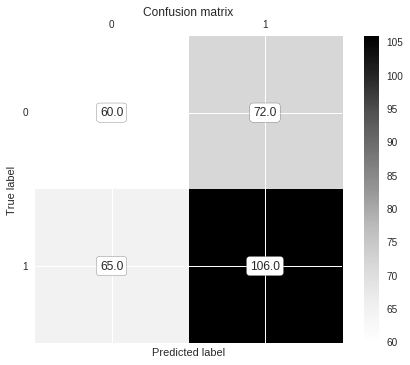

             precision    recall  f1-score   support

         -1       0.45      0.48      0.47       125
          1       0.62      0.60      0.61       178

avg / total       0.55      0.55      0.55       303

Area under the curve (AUC) is: 0.537752808989


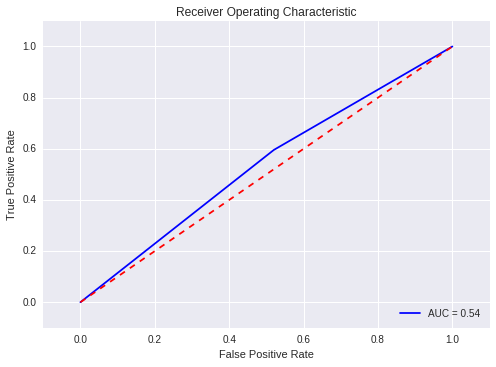

In [38]:
prediction = randomForestClassifier.predict(testDataCls)
evaluateCls(prediction, testOutputCls, ['-1', '1'])

# Restructuring Data
It seems SVM performs better Random Forest in both regression and classification. However, there is one problem with the approach so far. The problem being so far it is predicting stock value of the week using sentiment of the week. This is worthless information for the investor, what is vital is future prediction using past data. To achieve this, I will have to restructure the available dataset. The restructuring would creating new features from the data, which will be taking the mean,median,gradient mean and standard deviation of the past 9 days of a stock value. In other words, if I have have data for 10 days, I will use information of the past 9 days to generate features for the 10th day. (Past 9 days = Features, 10th day = Target).

In [39]:
weekholder = msftweek.index
investor = investor.loc[weekholder]
def makenewfeature(window, Series):
    name=Series.name
    index=[]
    mean=[]
    std=[]
    median=[]
    gradient=[]
    for count in range(len(weekholder)):
        frame=count+window
        if(frame<len(weekholder)):
            index.append(weekholder[frame])
            mean.append(np.mean(Series[count:frame]))
            std.append(np.std(Series[count:frame]))
            median.append(np.median(Series[count:frame]))
            gradient.append(np.mean(np.gradient(Series[count:frame])))
    df = pd.DataFrame(index=index, data={name+'_mean': mean, name+"_std":std, name+"_median":median, name+"_gradient":gradient})
    return df

In [40]:
statsOpen = makenewfeature(9, msftweek.Open)
statsClose = makenewfeature(9, msftweek.Close)
statsBullish = makenewfeature(9, investor.Bullish)
statsNeutral = makenewfeature(9, investor.Neutral)
statsBearish = makenewfeature(9, investor.Bearish)
statsVolume = makenewfeature(9, msftweek.Volume)

In [41]:
frames = [statsOpen, statsBullish, statsNeutral, statsBearish]
newfeatures = pd.concat(frames, axis=1)
newfeatures.head()

,Open_gradient,Open_mean,Open_median,Open_std,Bullish_gradient,Bullish_mean,Bullish_median,Bullish_std,Neutral_gradient,Neutral_mean,Neutral_median,Neutral_std,Bearish_gradient,Bearish_mean,Bearish_median,Bearish_std
1987-09-18,1.304630,104.637037,102.208333,6.877166,0.015929,0.457158,0.45,0.111823,0.004550,0.294745,0.28,0.121980,-0.020479,0.248097,0.27,0.096415
1987-09-25,1.982870,106.501852,103.333333,7.636658,0.026667,0.481111,0.50,0.116661,-0.021111,0.292222,0.28,0.121818,-0.005556,0.226667,0.26,0.103064
1987-10-02,-6.444444,102.825926,103.333333,14.604782,0.042778,0.500000,0.52,0.109036,-0.059444,0.255556,0.23,0.101774,0.016667,0.244444,0.27,0.100345
1987-10-09,-3.254630,99.034259,103.333333,18.969834,-0.024444,0.520000,0.52,0.074087,0.028333,0.231111,0.23,0.064540,-0.003889,0.248889,0.29,0.101811
1987-10-16,-2.629630,96.557407,103.333333,20.615426,0.013889,0.508889,0.50,0.074751,0.007778,0.257778,0.26,0.074353,-0.021667,0.233333,0.27,0.104987


In [42]:
expected = msftweek.loc[newfeatures.index]
expected.head()

,Open,Close,High,Low,Volume
1987-09-18,116.916667,116.855000,118.250000,115.208333,5.556000e+07
1987-09-25,67.041667,68.208333,69.936667,66.500000,8.463253e+07
1987-10-02,64.541667,66.250000,67.270000,64.228333,9.665920e+07
1987-10-09,73.500000,73.666667,75.958333,71.396667,1.392453e+08
1987-10-16,71.791667,70.500000,74.041667,69.458333,1.268613e+08


In [43]:
trainData = newfeatures[:(int)(len(newfeatures)*0.8)]
testData = newfeatures[(-(int)(len(newfeatures)*0.2)):]
trainOutput = expected.Open[:(int)(len(newfeatures)*0.8)]
testOutput = expected.Open[(-(int)(len(newfeatures)*0.2)):]
UpDownCls=UpDownCls[newfeatures.index]
trainDataCls = newfeatures[:(int)(len(newfeatures)*0.8)]
testDataCls = newfeatures[(-(int)(len(newfeatures)*0.2)):]
trainOutputCls = UpDownCls[:(int)(len(newfeatures)*0.8)]
testOutputCls = UpDownCls[(-(int)(len(newfeatures)*0.2)):]